In [1]:
!pip install pyspark



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import pyspark
import pyspark.sql  as pyspark_sql
import pyspark.sql.types as pyspark_types
import pyspark.sql.functions  as pyspark_functions
from pyspark import SparkContext, SparkConf
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [3]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

In [4]:
# create the context
sc = pyspark.SparkContext(conf=conf)
spark = pyspark_sql.SparkSession.builder.getOrCreate()

## Loading the datasets

In [5]:
col_mat_nuw_dataset = spark.read.csv("dataset\col_mat_nuw_output.csv", header=False, inferSchema=True)
mon_kur_jaf_dataset = spark.read.csv("dataset\kan_output.csv", header=False, inferSchema=True)
kan_dataset = spark.read.csv("dataset\mon_kur_jaf_output.csv", header=False, inferSchema=True)

col_mat_nuw_dataset = col_mat_nuw_dataset.toDF("HCHO reading", "Location", "Current Date", "Next Date")
mon_kur_jaf_dataset = mon_kur_jaf_dataset.toDF("HCHO reading", "Location", "Current Date", "Next Date")
kan_dataset = kan_dataset.toDF("HCHO reading", "Location", "Current Date", "Next Date")

col_mat_nuw_dataset.show()
mon_kur_jaf_dataset.show()
kan_dataset.show()

+--------------------+--------------+------------+----------+
|        HCHO reading|      Location|Current Date| Next Date|
+--------------------+--------------+------------+----------+
|1.969834395781014...|Colombo Proper|  2019-01-01|2019-01-02|
|2.625522171968594...|Colombo Proper|  2019-01-02|2019-01-03|
|9.852118897938794E-5|Colombo Proper|  2019-01-03|2019-01-04|
|2.099320518114242E-4|Colombo Proper|  2019-01-04|2019-01-05|
|1.785337298892930...|Colombo Proper|  2019-01-05|2019-01-06|
|1.082296700235670...|Colombo Proper|  2019-01-06|2019-01-07|
|3.926829280477309...|Colombo Proper|  2019-01-07|2019-01-08|
|9.153156350685351E-5|Colombo Proper|  2019-01-08|2019-01-09|
|1.205978992853015...|Colombo Proper|  2019-01-09|2019-01-10|
|1.297723562983258...|Colombo Proper|  2019-01-10|2019-01-11|
|2.239188166801278...|Colombo Proper|  2019-01-11|2019-01-12|
|1.569418094178759...|Colombo Proper|  2019-01-12|2019-01-13|
|                NULL|Colombo Proper|  2019-01-13|2019-01-14|
|1.33629

In [6]:
col_mat_nuw_dataset.printSchema()
mon_kur_jaf_dataset.printSchema()
kan_dataset.printSchema()

root
 |-- HCHO reading: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- Current Date: date (nullable = true)
 |-- Next Date: date (nullable = true)

root
 |-- HCHO reading: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- Current Date: date (nullable = true)
 |-- Next Date: date (nullable = true)

root
 |-- HCHO reading: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- Current Date: date (nullable = true)
 |-- Next Date: date (nullable = true)



In [7]:
from pyspark.sql.functions import col, sum

# Sum null values for each column
for dataset in [col_mat_nuw_dataset, mon_kur_jaf_dataset, kan_dataset]:
    null_counts = dataset.select([sum(col(c).isNull().cast("int")).alias(c) for c in dataset.columns])
    # Convert to Pandas DataFrame for easier display
    null_counts_pd = null_counts.toPandas()
    print("Null value counts for each column:")
    print(null_counts_pd)

Null value counts for each column:
   HCHO reading  Location  Current Date  Next Date
0          2419         0             0          0
Null value counts for each column:
   HCHO reading  Location  Current Date  Next Date
0           793         0             0          0
Null value counts for each column:
   HCHO reading  Location  Current Date  Next Date
0          1652         0             0          0


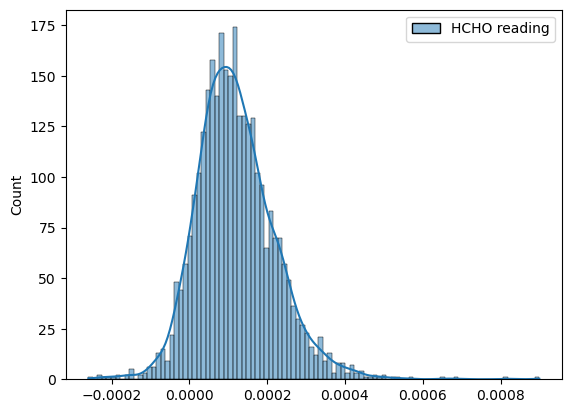

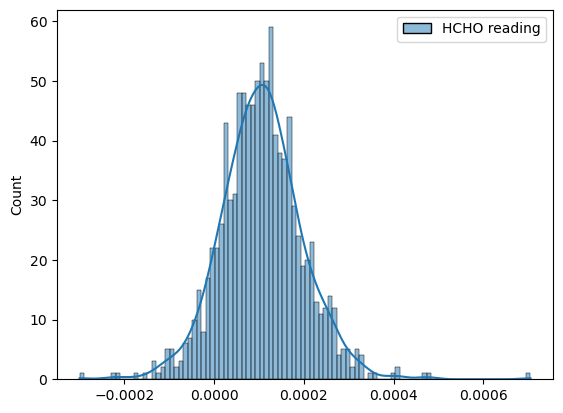

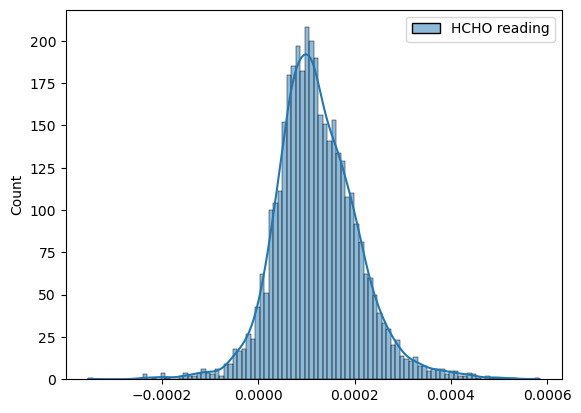

In [8]:


for dataset in [col_mat_nuw_dataset, mon_kur_jaf_dataset, kan_dataset]:
    # Convert PySpark DataFrame to Pandas DataFrame for plotting
    dataset_pd = dataset.toPandas()

    # Plot histograms for each numeric column
    sns.histplot(data=dataset_pd, bins=100, kde=True)
    plt.show()

In [9]:
concatenated_df = col_mat_nuw_dataset.union(mon_kur_jaf_dataset).union(kan_dataset)
concatenated_df.show()

+--------------------+--------------+------------+----------+
|        HCHO reading|      Location|Current Date| Next Date|
+--------------------+--------------+------------+----------+
|1.969834395781014...|Colombo Proper|  2019-01-01|2019-01-02|
|2.625522171968594...|Colombo Proper|  2019-01-02|2019-01-03|
|9.852118897938794E-5|Colombo Proper|  2019-01-03|2019-01-04|
|2.099320518114242E-4|Colombo Proper|  2019-01-04|2019-01-05|
|1.785337298892930...|Colombo Proper|  2019-01-05|2019-01-06|
|1.082296700235670...|Colombo Proper|  2019-01-06|2019-01-07|
|3.926829280477309...|Colombo Proper|  2019-01-07|2019-01-08|
|9.153156350685351E-5|Colombo Proper|  2019-01-08|2019-01-09|
|1.205978992853015...|Colombo Proper|  2019-01-09|2019-01-10|
|1.297723562983258...|Colombo Proper|  2019-01-10|2019-01-11|
|2.239188166801278...|Colombo Proper|  2019-01-11|2019-01-12|
|1.569418094178759...|Colombo Proper|  2019-01-12|2019-01-13|
|                NULL|Colombo Proper|  2019-01-13|2019-01-14|
|1.33629

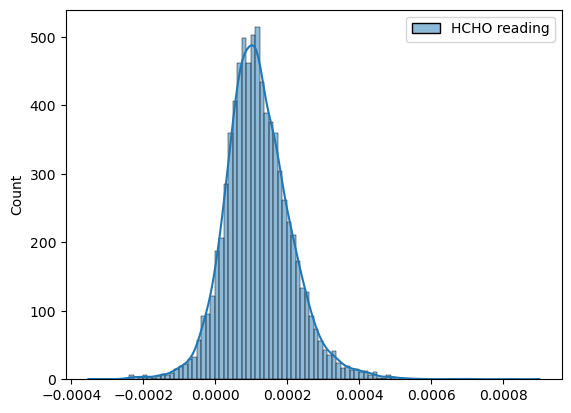

In [10]:
dataset_pd = concatenated_df.toPandas()
# Plot histograms for each numeric column
sns.histplot(data=dataset_pd, bins=100, kde=True)
plt.show()

In [11]:
def fill_with_last_and_next(df, ordering_column):
    # Define window specifications
    forward_window = Window.orderBy(ordering_column).rowsBetween(Window.unboundedPreceding, 0)
    backward_window = Window.orderBy(ordering_column).rowsBetween(0, Window.unboundedFollowing)
    
    # Fill null values with the last observation forward
    filled_df_forward = df.withColumn("HCHO reading", F.last("HCHO reading", True).over(forward_window))
    
    # Fill null values with the next observation backward
    filled_df_backward = filled_df_forward.withColumn("HCHO reading", F.first("HCHO reading", True).over(backward_window))
    
    return filled_df_backward

# Apply the custom function to your concatenated DataFrame
filled_df_custom = fill_with_last_and_next(concatenated_df, "Current Date")

# Show the resulting DataFrame
filled_df_custom.show()


+--------------------+-------------------+------------+----------+
|        HCHO reading|           Location|Current Date| Next Date|
+--------------------+-------------------+------------+----------+
|1.969834395781014...|     Colombo Proper|  2019-01-01|2019-01-02|
|1.969834395781014...|   Deniyaya, Matara|  2019-01-01|2019-01-02|
|1.969834395781014...|Nuwara Eliya Proper|  2019-01-01|2019-01-02|
|1.760713459877335...|       Kandy Proper|  2019-01-01|2019-01-02|
|1.760713459877335...| Bibile, Monaragala|  2019-01-01|2019-01-02|
|8.829725542537962E-5|  Kurunegala Proper|  2019-01-01|2019-01-02|
|5.830909719406619E-5|      Jaffna Proper|  2019-01-01|2019-01-02|
|2.625522171968594...|     Colombo Proper|  2019-01-02|2019-01-03|
|5.803530712000793E-6|   Deniyaya, Matara|  2019-01-02|2019-01-03|
|5.803530712000793E-6|Nuwara Eliya Proper|  2019-01-02|2019-01-03|
|9.220391253917748E-5|       Kandy Proper|  2019-01-02|2019-01-03|
|1.919914652467399E-5| Bibile, Monaragala|  2019-01-02|2019-01

In [12]:
filled_df_custom.select(*[sum(col(c).isNull().cast("int")).alias(c) for c in filled_df_custom.columns]).show()

+------------+--------+------------+---------+
|HCHO reading|Location|Current Date|Next Date|
+------------+--------+------------+---------+
|           0|       0|           0|        0|
+------------+--------+------------+---------+



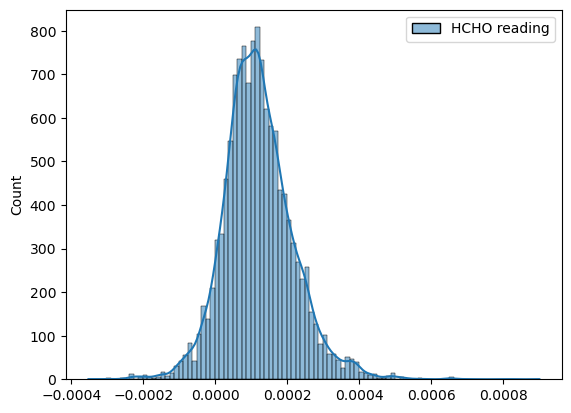

In [13]:
# Plot histograms for each numeric column
sns.histplot(data=filled_df_custom.toPandas(), bins=100, kde=True)
plt.show()

In [14]:
filled_df_custom.count()

12782

In [15]:
filled_df_custom.describe('HCHO reading').show()


+-------+--------------------+
|summary|        HCHO reading|
+-------+--------------------+
|  count|               12782|
|   mean|1.198404653912504...|
| stddev|9.705031733582523E-5|
|    min|-3.52473024357239...|
|    max|8.997101837438971E-4|
+-------+--------------------+



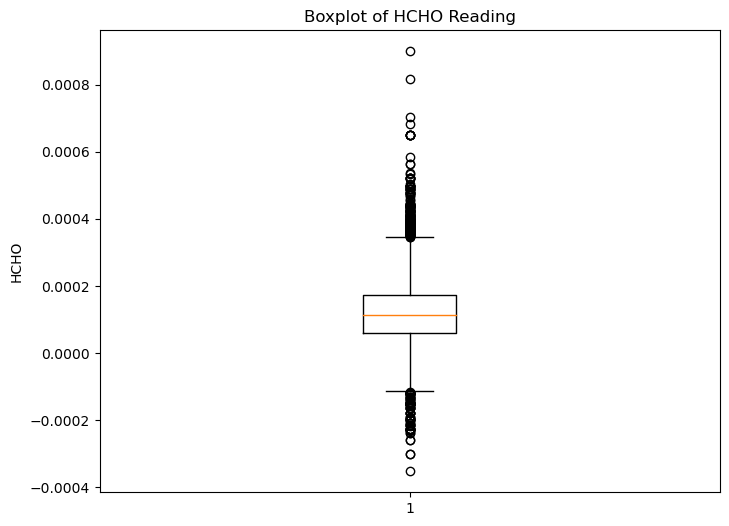

In [16]:

plt.figure(figsize=(8,6))
plt.boxplot(filled_df_custom.toPandas()['HCHO reading'])
plt.title("Boxplot of HCHO Reading")
plt.ylabel('HCHO')
plt.show()

In [17]:
# def replace_outliers_zscore(df, column_name, threshold):
#     # Calculate mean and standard deviation
#     mean_value = df.select(F.mean(column_name)).collect()[0][0]
#     std_value = df.select(F.stddev(column_name)).collect()[0][0]

#     # Calculate z-score
#     df_with_zscore = df.withColumn("z_score", F.abs((F.col(column_name) - mean_value) / std_value))
#     # Replace outliers with a predefined value (e.g., null)
#     df_with_replaced_outliers = df_with_zscore.withColumn(column_name, 
#                                                           F.when(F.col("z_score") <= threshold, 
#                                                                  F.col(column_name)).otherwise(None))

#     return df_with_replaced_outliers

# # Define the threshold for identifying outliers based on z-score (e.g., 3)
# zscore_threshold = 4

# # Apply the Z-Score method to the filled_df_custom dataset
# filled_df_custom_outliers_replaced = replace_outliers_zscore(filled_df_custom, "HCHO reading", zscore_threshold)

# # Show the resulting DataFrame
# filled_df_custom_outliers_replaced.show()

NameError: name 'filled_df_custom_outliers_replaced' is not defined

In [32]:
def replace_outliers_zscore(df, column_name, threshold):
    # Calculate mean and standard deviation
    mean_value = df.select(F.mean(column_name)).collect()[0][0]
    std_value = df.select(F.stddev(column_name)).collect()[0][0]

    # Calculate z-score
    df_with_zscore = df.withColumn("z_score", F.abs((F.col(column_name) - mean_value) / std_value))
    
    # Replace outliers with the last observation
    df_with_replaced_outliers = df_with_zscore.withColumn(column_name, 
                                                          F.when(F.col("z_score") <= threshold, 
                                                                 F.col(column_name)).otherwise(None))

    return df_with_replaced_outliers

# Define the threshold for identifying outliers based on z-score (e.g., 2 or 1)
zscore_threshold = 7  # You can adjust this threshold as needed

# Apply the Z-Score method to the filled_df_custom dataset
filled_df_custom_outliers_replaced = replace_outliers_zscore(filled_df_custom, "HCHO reading", zscore_threshold)

# Show the resulting DataFrame
filled_df_custom_outliers_replaced.show()

+--------------------+-------------------+------------+----------+-------------------+
|        HCHO reading|           Location|Current Date| Next Date|            z_score|
+--------------------+-------------------+------------+----------+-------------------+
|1.969834395781014...|     Colombo Proper|  2019-01-01|2019-01-02|  0.794876063309629|
|1.969834395781014...|   Deniyaya, Matara|  2019-01-01|2019-01-02|  0.794876063309629|
|1.969834395781014...|Nuwara Eliya Proper|  2019-01-01|2019-01-02|  0.794876063309629|
|1.760713459877335...|       Kandy Proper|  2019-01-01|2019-01-02| 0.5793992450525041|
|1.760713459877335...| Bibile, Monaragala|  2019-01-01|2019-01-02| 0.5793992450525041|
|8.829725542537962E-5|  Kurunegala Proper|  2019-01-01|2019-01-02|0.32501913267033666|
|5.830909719406619E-5|      Jaffna Proper|  2019-01-01|2019-01-02| 0.6340151159348197|
|2.625522171968594...|     Colombo Proper|  2019-01-02|2019-01-03| 1.4704923767717373|
|5.803530712000793E-6|   Deniyaya, Matara| 

In [33]:
filled_df_custom_outliers_replaced.select(*[sum(col(c).isNull().cast("int")).alias(c) for c in filled_df_custom_outliers_replaced.columns]).show()

+------------+--------+------------+---------+-------+
|HCHO reading|Location|Current Date|Next Date|z_score|
+------------+--------+------------+---------+-------+
|           2|       0|           0|        0|      0|
+------------+--------+------------+---------+-------+



In [35]:
filled_df_custom_outliers_replaced.describe('HCHO reading').show()


+-------+--------------------+
|summary|        HCHO reading|
+-------+--------------------+
|  count|               12780|
|   mean|1.197249087126338...|
| stddev|9.661584355345821E-5|
|    min|-3.52473024357239...|
|    max|7.051621763962024E-4|
+-------+--------------------+



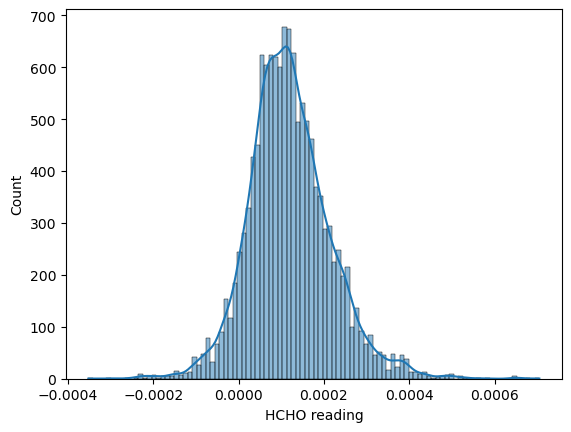

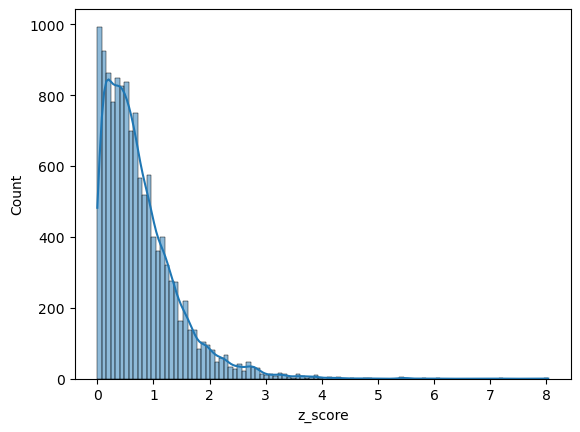

In [34]:
dataset_pd = filled_df_custom_outliers_replaced.toPandas()
# Plot histograms for each numeric column
sns.histplot(data=dataset_pd["HCHO reading"], bins=100, kde=True)
plt.show()

sns.histplot(data=dataset_pd["z_score"], bins=100, kde=True)
plt.show()

In [ ]:
dataset_pd["z_score"].max()

8.035725588140503

In [ ]:
dataset_pd

,HCHO reading,Location,Current Date,Next Date,z_score
0,0.000197,Colombo Proper,2019-01-01,2019-01-02,0.794876
1,0.000197,"Deniyaya, Matara",2019-01-01,2019-01-02,0.794876
2,0.000197,Nuwara Eliya Proper,2019-01-01,2019-01-02,0.794876
3,0.000176,Kandy Proper,2019-01-01,2019-01-02,0.579399
4,0.000176,"Bibile, Monaragala",2019-01-01,2019-01-02,0.579399
...,...,...,...,...,...
12777,0.000080,Nuwara Eliya Proper,2023-12-31,2024-01-01,0.406771
12778,0.000080,Kandy Proper,2023-12-31,2024-01-01,0.406771
12779,0.000080,"Bibile, Monaragala",2023-12-31,2024-01-01,0.406771
12780,0.000080,Kurunegala Proper,2023-12-31,2024-01-01,0.406771


In [ ]:
dataset_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12782 entries, 0 to 12781
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HCHO reading  12758 non-null  float64
 1   Location      12782 non-null  object 
 2   Current Date  12782 non-null  object 
 3   Next Date     12782 non-null  object 
 4   z_score       12782 non-null  float64
dtypes: float64(2), object(3)
memory usage: 499.4+ KB


In [ ]:
dataset_pd.isna().sum()


HCHO reading    24
Location         0
Current Date     0
Next Date        0
z_score          0
dtype: int64

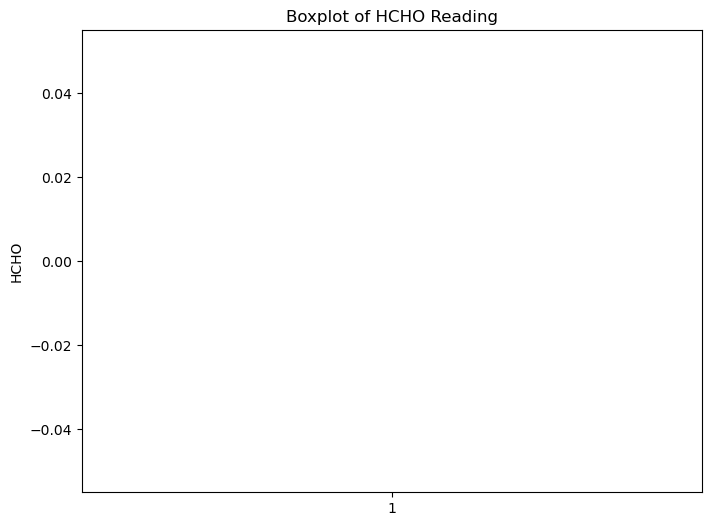

In [ ]:
plt.figure(figsize=(8,6))
plt.boxplot(dataset_pd['HCHO reading'])
plt.title("Boxplot of HCHO Reading")
plt.ylabel('HCHO')
plt.show()

In [ ]:
# dataset_pd.to_csv('artifacts\\preprocessed_dataset.csv', index=False)